In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim


In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [3]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data/cifar10', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True, num_workers=0)
testset = torchvision.datasets.CIFAR10(root='./data/cifar10', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


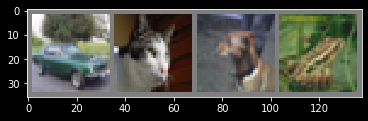

car   cat   dog  frog


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def testNet(testloader, net):
    running_loss = 0.0
    correct = 0.0
    for i, (inputs, labels) in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = inputs.to(device), labels.to(device)    
        outputs = net(inputs)
        correct += float(sum(torch.argmax(outputs, dim=1)==labels))
        loss = criterion(outputs, labels)
        running_loss += loss.item()
    print('running loss: {0}'.format(running_loss/i))
    print('correctly predict {0}/{1}'.format(correct, (i+1)*testloader.batch_size))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
# but GPU usage is just 10% or so...observed by nvidia inspector
useCuda = torch.cuda.is_available()
device = torch.device("cuda" if useCuda else "cpu")


In [6]:
# initialize neural net, setup loss and optimizer
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


please set 'preTrained' to False if you don't have a preTrained model for this task.

In [7]:
preTrained = True
PATH = 'assignment3/cifar_net.pth'
if preTrained:
    net.load_state_dict(torch.load(PATH))
    net.eval()
else:
    for epoch in range(3):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    print('Finished Training')
    torch.save(net.state_dict(), PATH)

print('\nreview the output on train set')    
testNet(trainloader, net)



review the output on train set
running loss: 1.0840841238046037
correctly predict 31000.0/50000


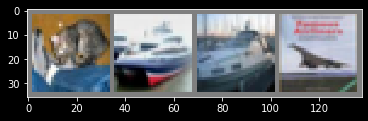

GroundTruth:    cat  ship  ship plane
Predict:    cat   car  ship plane

begin testing the model on test set
running loss: 1.1872370821468923
correctly predict 5896.0/10000


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()
# print images
imshow(torchvision.utils.make_grid(images))
out = net(images.to(device))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print('Predict: ', ' '.join('%5s' % classes[predicted] for predicted in torch.argmax(out, dim=1)))

print('\nbegin testing the model on test set')
testNet(testloader, net)

calculate the accuracy for each class

In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 58 %
Accuracy of   car : 80 %
Accuracy of  bird : 46 %
Accuracy of   cat : 32 %
Accuracy of  deer : 50 %
Accuracy of   dog : 53 %
Accuracy of  frog : 77 %
Accuracy of horse : 72 %
Accuracy of  ship : 59 %
Accuracy of truck : 58 %
